# Ciencia de datos (CC408) - Primavera 2024

## Trabajo Práctico 1 - Parte 2

### Reglas de formato y presentation
- El trabajo debe tener una extensión máxima de 8 páginas (no se permite Apéndice). Se espera una buena redacción en la resolución del práctico.
- El informe debe ser entregado en formato PDF, con los gráficos e imágenes en este mismo archivo.
- Entregar el código con los comandos utilizados, identificando claramente a qué inciso corresponde cada comando.

### Fecha de entrega:
Miércoles 2 de octubre a las 23:59 hs.

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub llamado “Entrega final del tp”. 
- Asegurense de haber creado una carpeta llamada TP1. Este Jupyter Notebook y el correspondiente al TP1 - Parte 2 deben estar dentro de esa carpeta.
- También deben enviar el link de su repositorio -para que pueda ser clonado y corregido- al siguiente email: ispiousas@udesa.edu.ar
- La última versión en el repositorio es la que será evaluada. Por lo que es importante que: 
    - No envien el correo hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, no se corregirán sus tareas hasta no recibir el correo.
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija. 

### Parte I: Limpieza de la base

#### Ejercicio 1
La base de datos provista contiene información sobre oferentes de Airbnb en la ciudad de Nueva York. Realicen una limpieza de la base.
- Tengan en cuenta si hay valores duplicados y eliminénlos.
- Eliminen las columnas que no tienen información de interés.
- (Opcional) Luego de leer el artículo __[Missing-data imputation](https://bookdown.org/mike/data_analysis/imputation-missing-data.html##imputation-missing-data)__ (__[Missing-data imputation articulo alternativo](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)__), decidan qué hacer con los missing values e implementen su decision. Justifiquen su eleccion. Pueden usar informacion del paper mencionado o de otras fuentes (citenlas si las usan) para explicar los problemas que pueden surgir por su estrategia elegida.
- Si hay observaciones con *outliers* o valores que no tienen sentido, tomen una decision. Expliquen las decisiones tomadas.
- Transformen las variables **‘neighbourhood_group’** y **‘room_type’** a variables numericas.
- Con la ayuda de los comandos <code>groupby</code> y <code>join</code> o <code>merge</code>, creen una columna que tenga la cantidad de oferentes por “Neighbourhood group”. Llamen a esa nueva columna <code>offer group</code>

In [42]:
# Importan las librerias
import pandas as pd 
import numpy as np


## 0. LECTURA DEL DOCUMENTO
df_airbnb = pd.read_csv("c:/Users/SAMSUNG/Documents/Udesa Primavera 2024/Ciencia de datos/TP2/Base Airbnb NY.csv")

#Dirección de Miyagi: "C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 2/Base Airbnb NY.csv"
#Dirección de Peter: "c:/Users/SAMSUNG/Documents/Udesa Primavera 2024/Ciencia de datos/TP2/Base Airbnb NY.csv"

##1. LIMPIEZA BASICA
# Se eliminan las columnas que no son relevantes
columns_drop = ['name','host_id','host_name','id']
df_airbnb = df_airbnb.drop(columns=columns_drop)


# Se eliminan duplicados
duplicates = df_airbnb[df_airbnb.duplicated()]
print("Number of duplicate rows:", len(duplicates))
if len(duplicates) > 0:
  df_airbnb = df_airbnb.drop_duplicates() 
  print("Duplicate rows removed.")
else:
  print("No duplicate rows found.")

#Elimino las filas cuyo price tengan valor 0
df_airbnb = df_airbnb[df_airbnb['price'] != 0]

## 2. SE AGREGAN COLUMNAS 
# Columnas agregadas
# - Last_review_days
# - Dummy por cada neigbourhood
# - Dummy por cada Room
# - Offer Group

#Last review a numero (distancia de la fecha al presente)
df_airbnb['last_review'] = pd.to_datetime(df_airbnb['last_review']) #Se tranforma a objeto
present = pd.to_datetime('today') #Se calcula la fecha presente
df_airbnb['last_review_days'] = (present - df_airbnb['last_review']).dt.days ## Se resta la fecha al presente

#Transformación de las variables ‘neighbourhood_group’ y ‘room_type’ a variables numericas.
dummy_neighbourhood = pd.get_dummies(df_airbnb['neighbourhood_group'], prefix='neighbourhood')
for column in dummy_neighbourhood.columns:
    dummy_neighbourhood[column] = dummy_neighbourhood[column].map(lambda x: 1 if x else 0)


dummy_room = pd.get_dummies(df_airbnb['room_type'], prefix='room')
for column in dummy_room.columns:
    dummy_room[column] = dummy_room[column].map(lambda x: 1 if x else 0)

df= pd.concat([df_airbnb, dummy_neighbourhood, dummy_room], axis=1)


# Con la ayuda de los comandos groupby y join o merge, creen una columna que tenga la cantidad de oferentes por “Neighbourhood group”. Llamen a esa nueva columna offer group#
offer_count = df.groupby('neighbourhood_group')['neighbourhood_group'].count().reset_index(name='offer_group')
df = pd.merge(df, offer_count, on='neighbourhood_group', how='left')

# pone un 0 en review_per_month cuando numbes_of_reviews es 0
df.loc[df['number_of_reviews'] == 0, 'reviews_per_month'] = 0

# Creo DF base sin las categoricas
drop_columns = ['neighbourhood_group','neighbourhood','room_type','last_review']
df_numbers = df.drop (columns =drop_columns)

Number of duplicate rows: 10
Duplicate rows removed.


<Axes: >

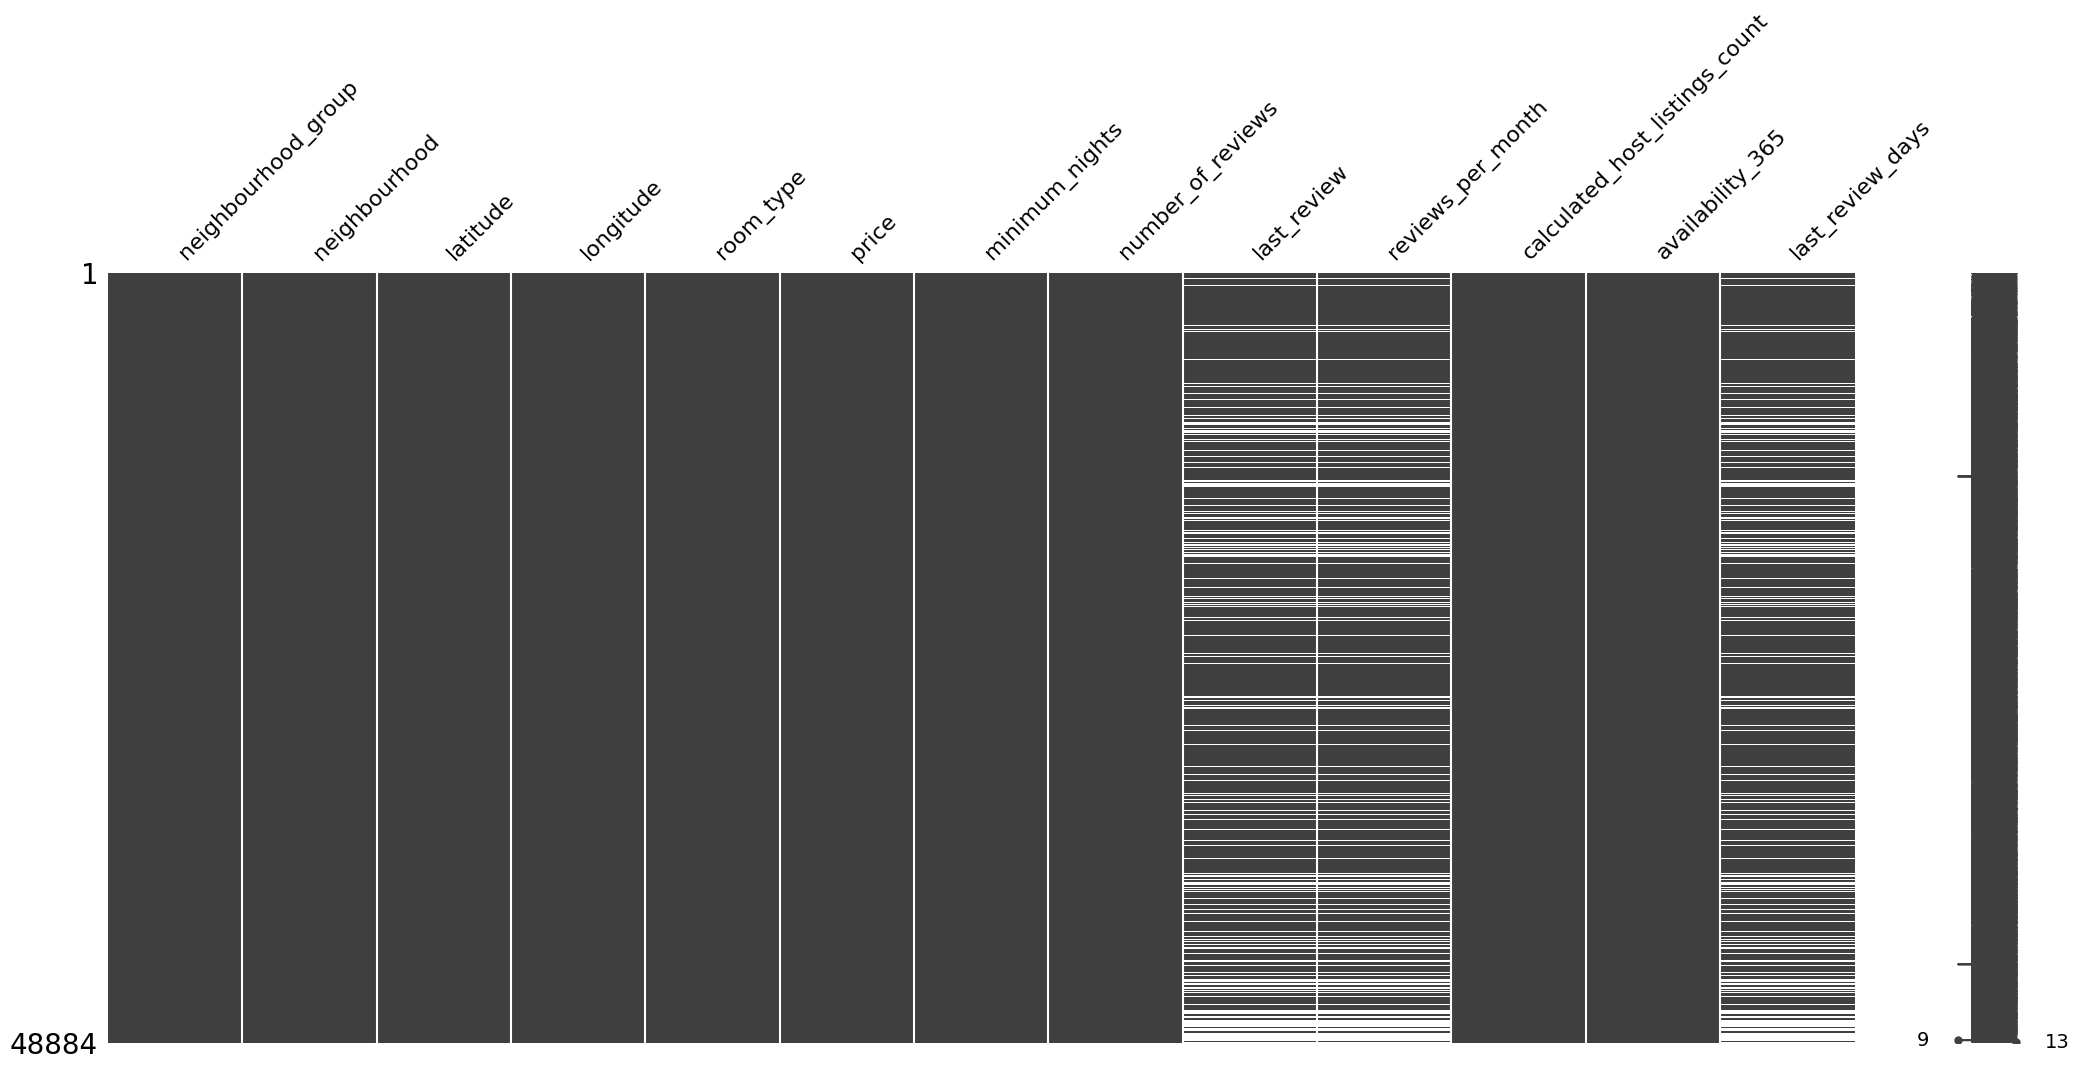

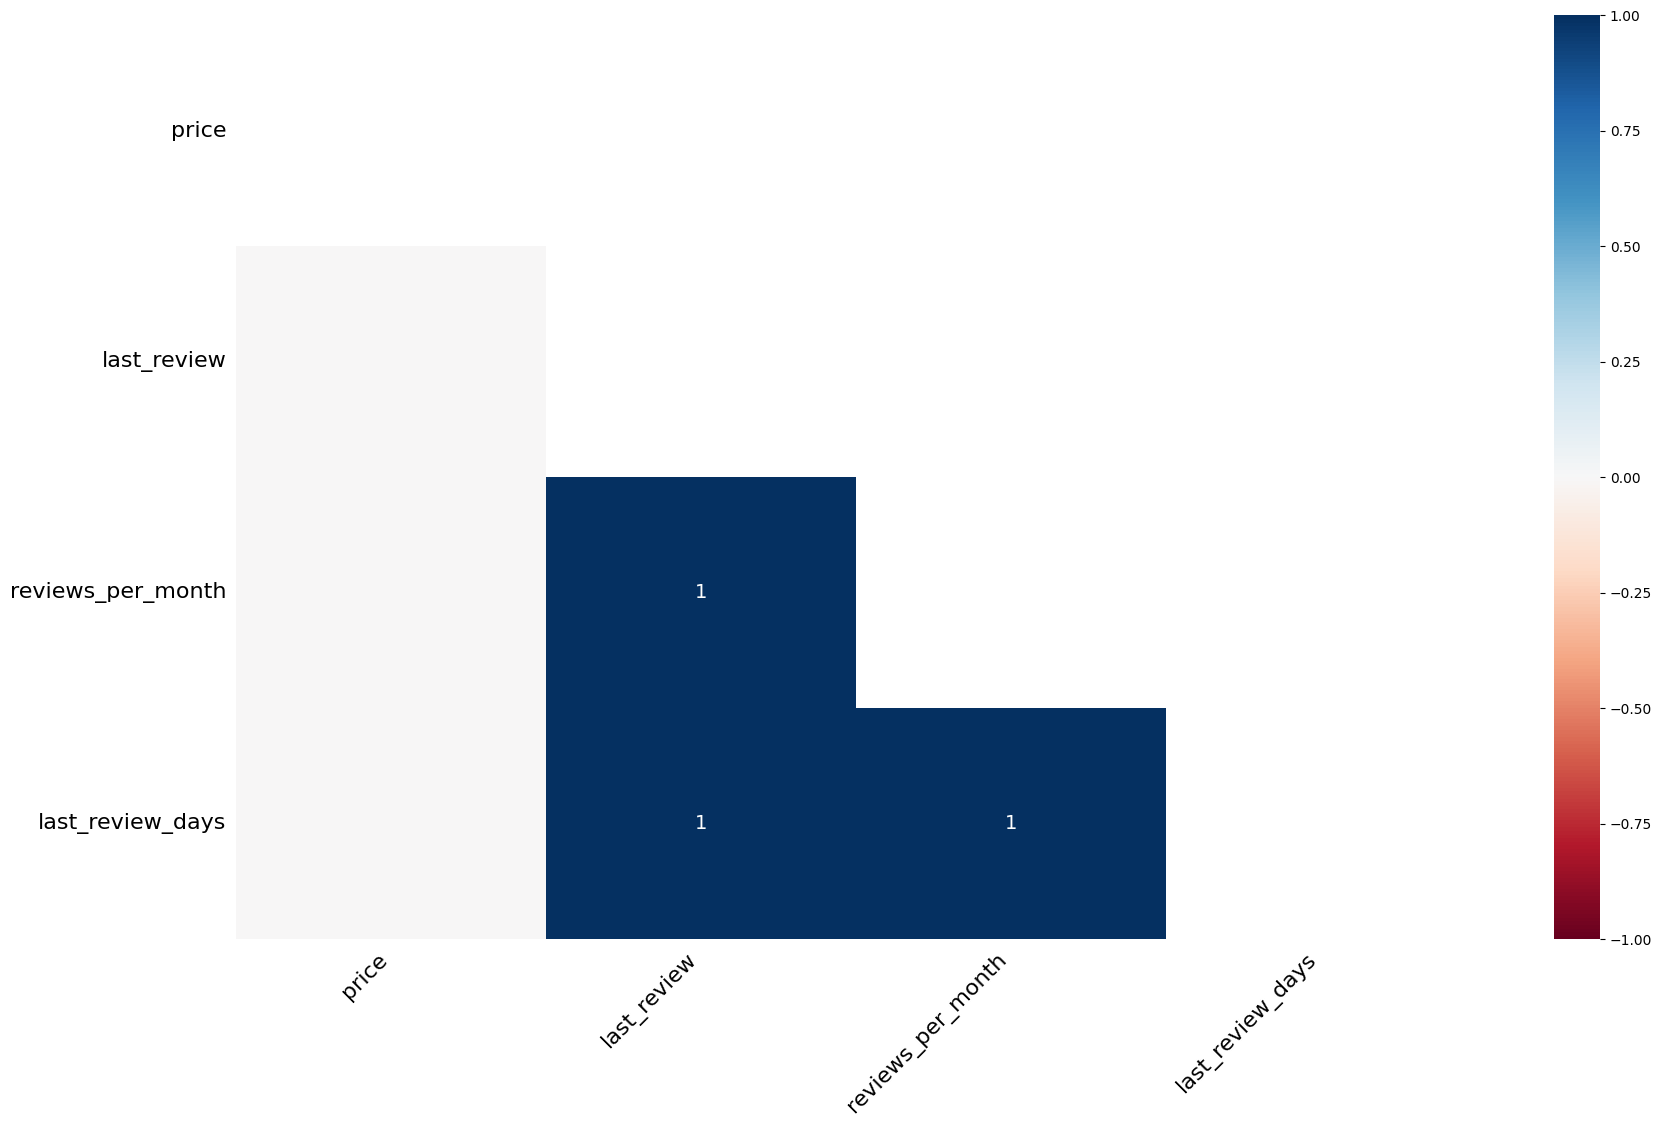

In [43]:
### 3. DIAGNOSTICO MISSING VALUES E IMPUTACION
#(Opcional) Luego de leer el artículo Missing-data imputation (Missing-data imputation articulo alternativo), decidan qué hacer con los missing values e implementen su decision. Justifiquen su eleccion. Pueden usar informacion del paper mencionado o de otras fuentes (citenlas si las usan) para explicar los problemas que pueden surgir por su estrategia elegida.
# https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python

# Visual de Missing Data
!pip install missingno
import missingno as msno
msno.matrix(df_airbnb)
msno.heatmap(df_airbnb)

In [44]:
# Eliminación e imputación de datos
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Elimino los datos de price y availability porque son muy pocos ... (y no parecen estra correlacionados?)
df.dropna(subset=['price'],how='any',inplace=True)
df['price'].isnull().sum()

df.dropna(subset=['availability_365'],how='any',inplace=True)
df['availability_365'].isnull().sum()

# MAR: Advanced predictive modeling techniques like regression, MICE, or machine learning.

mice_imputer = IterativeImputer()
df['reviews_per_month'] = mice_imputer.fit_transform(df[['reviews_per_month']])
df['last_review_days'] = mice_imputer.fit_transform(df[['last_review_days']])


# df.isnull().sum()

In [45]:
## Separación de df en uno base y en otro con columnas tranformadas
# transformación de las columnas con log
df_trans = df.copy()
lista_columnas_transformar = [
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']
for columna in lista_columnas_transformar:
  df_trans[columna] = df_trans[columna].replace(0,1)
  df_trans[columna] = np.log(df_trans[columna])

#### METODO TUKEY FALLIDO
# # Calcular la media y la desviación estándar de cada columna
# df_mean = df_numbers.mean()
# df_std = df_numbers.std()

# # Convertir los datos a puntuaciones Z
# df_z = (df_numbers - df_mean) / df_std

c:\Users\SAMSUNG\AnitaConda7\envs\Clasestuto\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
#Si hay observaciones con outliers o valores que no tienen sentido, tomen una decision. Expliquen las decisiones tomadas.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette="rainbow")
%matplotlib inline

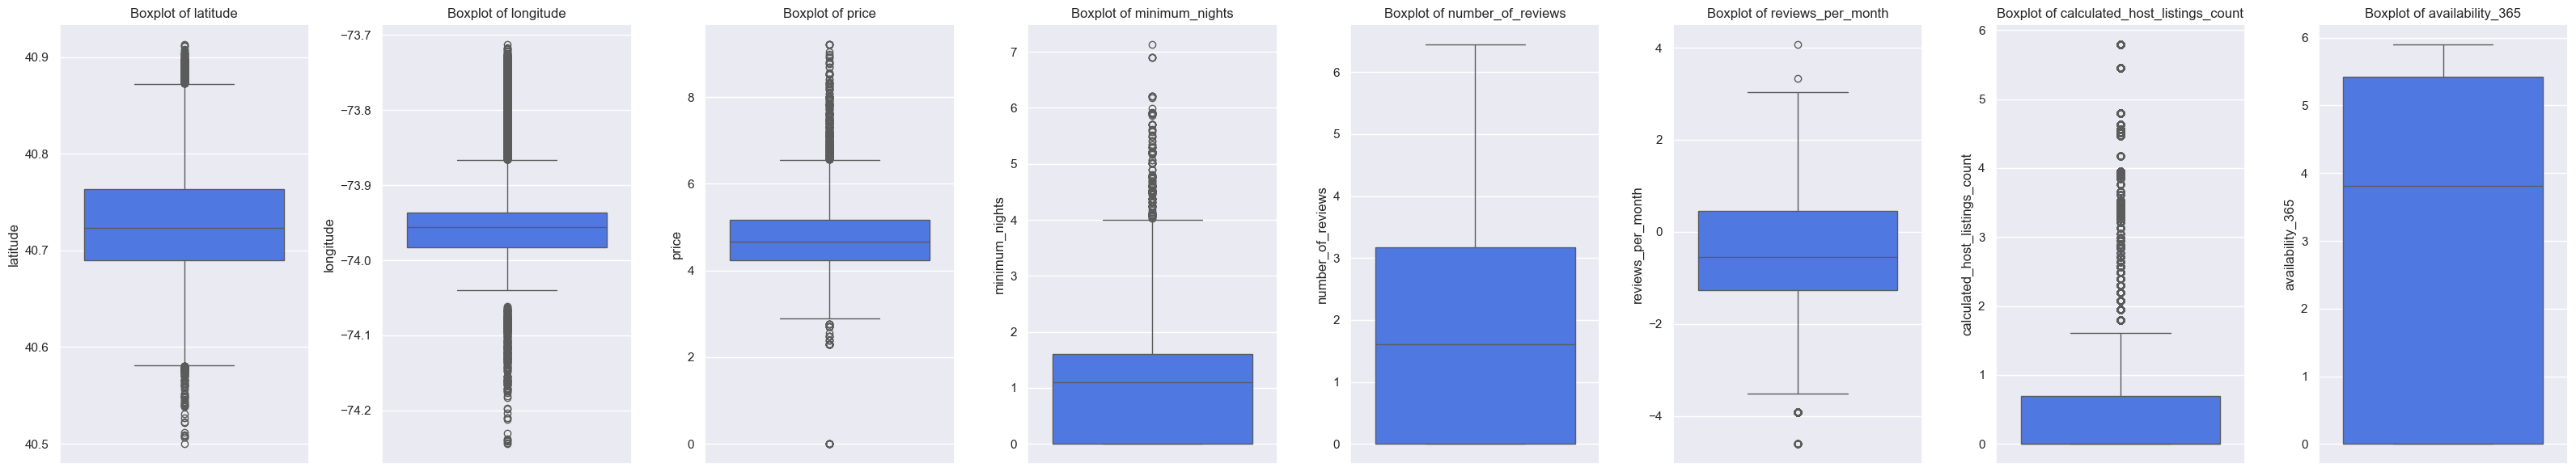

In [189]:
um_cols = len(df_airbnb_mice.select_dtypes(include=np.number).columns)
fig, axes = plt.subplots(1, num_cols, figsize=(4 * num_cols, 6))  # Adjust figsize as needed

i = 0
for column in df_airbnb_mice.select_dtypes(include=np.number):
    sns.boxplot(y=df_airbnb_mice[column], ax=axes[i])  # Create boxplot on the current subplot
    axes[i].set_title(f"Boxplot of {column}")  # Set subplot title
    axes[i].set_ylabel(column)  # Set subplot y-axis label
    i += 1

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot

In [447]:


# Calculate the IQR for each numerical column

for column in df_airbnb_mice.select_dtypes(include=np.number):
  Q1 = df_airbnb_mice[column].quantile(0.25)
  Q3 = df_airbnb_mice[column].quantile(0.75)
  IQR = Q3 - Q1

  # Define the outlier boundaries
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Identify outliers
  outliers = df_airbnb_mice[(df_airbnb_mice[column] < lower_bound) | (df_airbnb_mice[column] > upper_bound)]

  if len(outliers) > 0:
    if column != 'latitude':
      print(f"Outliers found in column '{column}':")
      print(outliers)

Outliers found in column 'longitude':
      neighbourhood_group  neighbourhood  latitude  longitude  \
143                Queens       Flushing  40.74028  -73.83168   
169         Staten Island     St. George  40.64524  -74.08088   
196                Queens        Jamaica  40.67252  -73.76597   
249         Staten Island  Tompkinsville  40.63536  -74.08537   
250         Staten Island  Tompkinsville  40.63627  -74.08543   
...                   ...            ...       ...        ...   
48847              Queens      Woodhaven  40.69183  -73.86523   
48851              Queens      Woodhaven  40.69137  -73.86591   
48858              Queens       Flushing  40.74387  -73.82556   
48866              Queens      Briarwood  40.70786  -73.81448   
48889              Queens        Jamaica  40.69137  -73.80844   

             room_type  price  minimum_nights  number_of_reviews last_review  \
143       Private room  140.0               2                  1  2011-09-19   
169       Private roo

,room_Entire home/apt,room_Private room,room_Shared room
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
48890,0,1,0
48891,0,1,0
48892,1,0,0
48893,0,0,1


In [399]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,...,last_review_days,neighbourhood_Bronx,neighbourhood_Brooklyn,neighbourhood_Manhattan,neighbourhood_Queens,neighbourhood_Staten Island,room_Entire home/apt,room_Private room,room_Shared room,offer_group
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1,9,2018-10-19,0.210000,...,2175.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20104
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,2019-05-21,0.380000,...,1961.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,21661
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3,0,NaT,1.373221,...,2189.925418,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,21661
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1,270,2019-07-05,4.640000,...,1916.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,20104
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,2018-11-19,0.100000,...,2144.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,21661


### Parte II: Graficos y visualizaciones

#### Ejercicio 2
Una vez hecha la limpieza, realicen una matriz de correlación con las siguientes variables:**‘neighbourhood group’, ‘latitude’, ‘longitude’, ‘room type’,‘price’, ‘minimum nights’, ‘number of reviews’, ‘reviews per month’,‘calculated host listings count’, ‘availability 365’.** Comenten los resultados. Utilicen alguno de los comandos disponibles en este link para graficar la matriz de correlacion.

*Nota:* consideren cómo es conveniente incluir las variables que originalmente eran categóricas para poder interpretar mejor la matriz de correlación.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


Text(0.5, 1.0, 'Matriz de correlación')

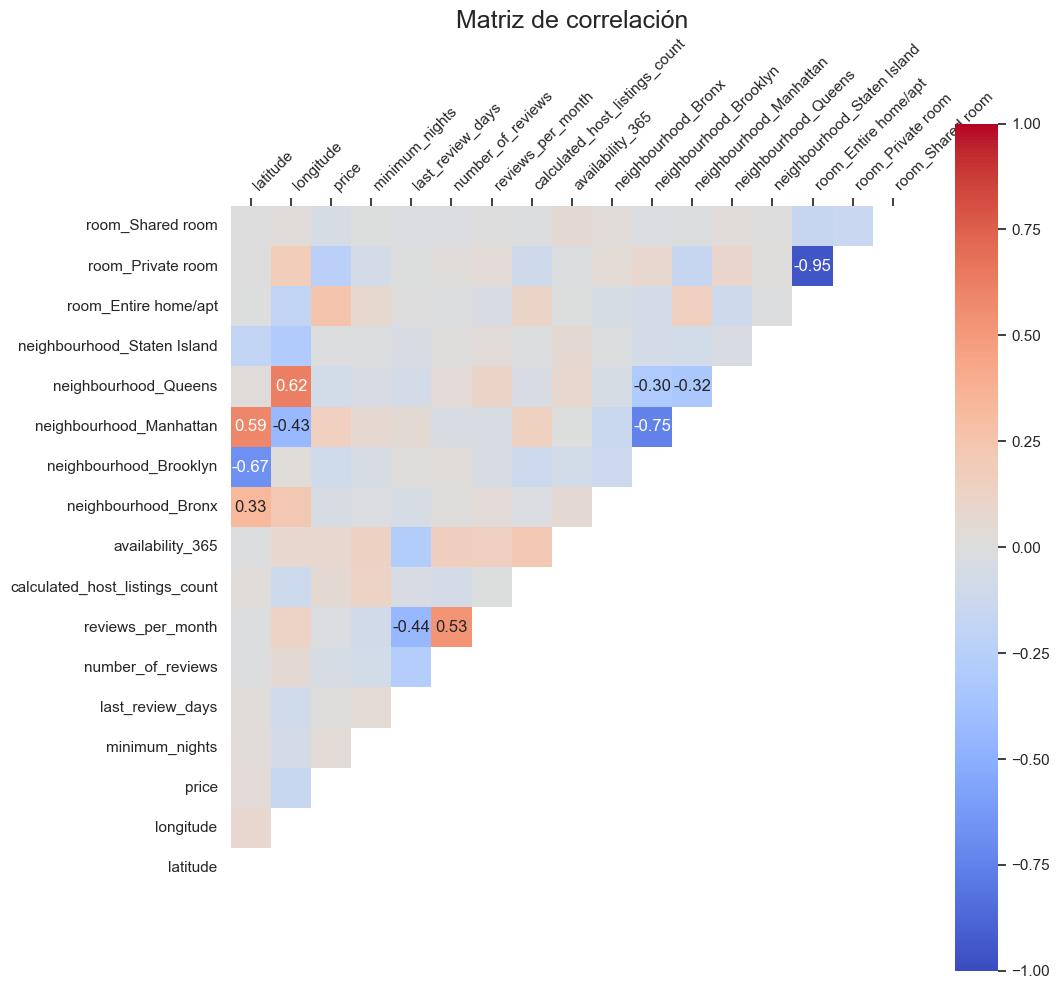

In [452]:
# Resolver acá
#columnas = df[[ 'latitude', 'longitude',  'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
columnas = df[['latitude', 'longitude', 'price', 'minimum_nights', 'last_review_days', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', "neighbourhood_Bronx","neighbourhood_Brooklyn","neighbourhood_Manhattan",	"neighbourhood_Queens",	"neighbourhood_Staten Island",	"room_Entire home/apt",	"room_Private room"	, "room_Shared room"	 ]]

correlacion = columnas.corr()
mask = np.zeros_like(correlacion)
mask[np.triu_indices_from(mask)] = True

# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
# annot_labels = np.empty_like(correlacion, dtype=str)
# annot_mask = abs(correlacion) <= 0.2
# annot_labels[~annot_mask] = correlacion[~annot_mask].round(2).astype(str)
# annot_labels[annot_mask] = ''  

annot_labels = np.empty(correlacion.shape, dtype=object)  # Cambiar a objeto para evitar problemas
for i in range(correlacion.shape[0]):
    for j in range(correlacion.shape[1]):
        if abs(correlacion.iloc[i, j]) > 0.3:  # Solo correlaciones mayores a 0.2
            annot_labels[i, j] = f"{correlacion.iloc[i, j]:.2f}"  # Formato de 2 decimales
        else:
            annot_labels[i, j] = ''  # Dejar vacío

# Plot hearmap with the annotations

plt.figure(figsize=(11,11), facecolor='white')

sns.heatmap(correlacion, vmax=1, vmin=-1, square=True, annot=annot_labels, fmt="", cmap='coolwarm', mask = mask, linewidths=0, linecolor='white')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

plt.gca().invert_yaxis()  
plt.gca().xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.title('Matriz de correlación', fontsize=18)


Text(0.5, 1.0, 'Correlación de variables con "Price"')

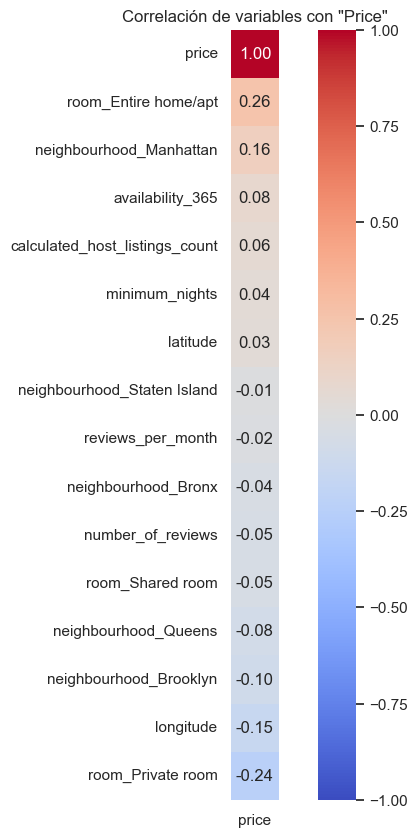

In [453]:
# Resolver acá
#columnas = df[[ 'latitude', 'longitude',  'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
columnas = df[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', "neighbourhood_Bronx","neighbourhood_Brooklyn","neighbourhood_Manhattan",	"neighbourhood_Queens",	"neighbourhood_Staten Island",	"room_Entire home/apt",	"room_Private room"	, "room_Shared room"	 ]]

correlacion = columnas.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlacion[["price"]].sort_values(by=["price"], ascending=False), vmax=1, vmin=-1, square=True, annot= True, fmt='.2f', cmap='coolwarm')

plt.title('Correlación de variables con "Price"', ha='center')

#### Ejercicio 3
Respondan las siguientes preguntas: ¿Cuál es la proporción de oferentes por “Neighbourhood group”? ¿Y por tipo de habitación? Además, realicen gráficos para mostrar estas composiciones y comenten los resultados.

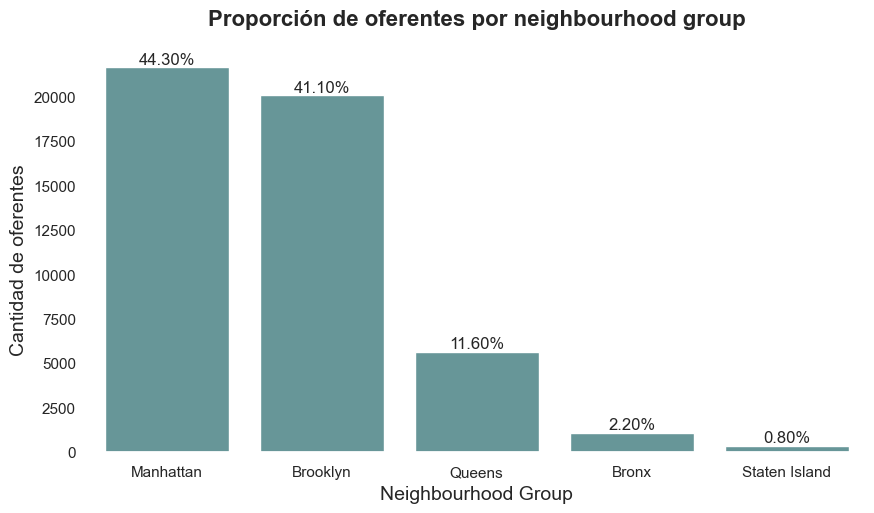

In [346]:
#Resolver acá

#Cantidad de oferentes por Neighbourhood group
oferentes_groups = df["neighbourhood_group"].value_counts()

#Proporción de oferentes por Neighbourhood group
proporciones_groups = df["neighbourhood_group"].value_counts(normalize=True).round(3)

# Gráfico de barras
plt.figure(figsize=(10, 5))
bar_plot = sns.barplot(x=oferentes_groups.index, y=oferentes_groups.values, color="cadetblue")

for index, value in enumerate(oferentes_groups.values):
   porcentaje= proporciones_groups[oferentes_groups.index[index]]*100
   bar_plot.text(index, value + 1, f'{porcentaje:.2f}%', ha='center', va='bottom')

plt.ylabel("Cantidad de oferentes", fontsize=14)
plt.title("Proporción de oferentes por neighbourhood group", fontsize=16, weight="bold", pad=30)
plt.xlabel("Neighbourhood Group", fontsize=14)
plt.ylim(0, oferentes_groups.max() + 10)  
plt.show()

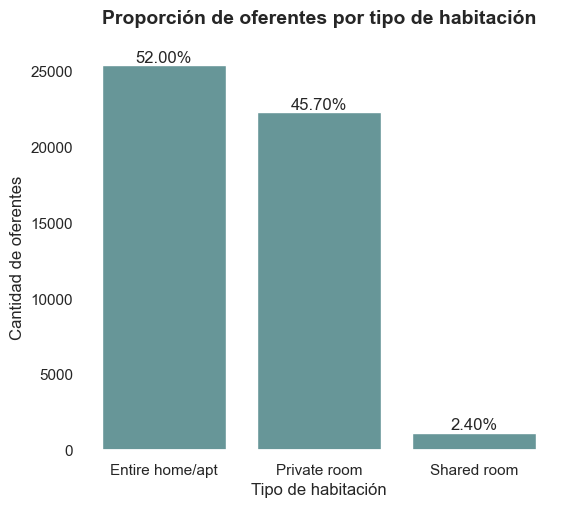

In [352]:
#Cantidad de oferentes por tipo de habitación
oferentes_rooms = df["room_type"].value_counts()

#Proporción de oferentes por tipo de habitación
proporciones_rooms = df["room_type"].value_counts(normalize=True).round(3)

# Gráfico de barras
plt.figure(figsize=(6, 5))
bar_plot = sns.barplot(x=oferentes_rooms.index, y=oferentes_rooms.values, color="cadetblue")

for index, value in enumerate(oferentes_rooms.values):
   porcentaje_r= proporciones_rooms[oferentes_rooms.index[index]]*100
   bar_plot.text(index, value + 1, f'{porcentaje_r:.2f}%', ha='center', va='bottom')

plt.ylabel("Cantidad de oferentes", fontsize=12)
plt.title("Proporción de oferentes por tipo de habitación", fontsize=14, weight="bold", pad=30)
plt.xlabel("Tipo de habitación", fontsize=12)
plt.ylim(0, oferentes_rooms.max() + 10)  
plt.show()

#### Ejercicio 4
Realicen un histograma de los precios de los alojamientos. Comenten el gráfico obtenido. Además, respondan las siguientes preguntas: ¿cuál es el precio mínimo, máximo y promedio? ¿Cuál es la media de precio por “Neighbourhood group” y por tipo de habitación? 

In [402]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,...,last_review_days,neighbourhood_Bronx,neighbourhood_Brooklyn,neighbourhood_Manhattan,neighbourhood_Queens,neighbourhood_Staten Island,room_Entire home/apt,room_Private room,room_Shared room,offer_group
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1,9,2018-10-19,0.210000,...,2175.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20104
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,2019-05-21,0.380000,...,1961.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,21661
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3,0,NaT,1.373221,...,2189.925418,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,21661
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1,270,2019-07-05,4.640000,...,1916.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,20104
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,2018-11-19,0.100000,...,2144.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,21661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70.0,2,0,NaT,1.373221,...,2189.925418,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20104
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40.0,4,0,NaT,1.373221,...,2189.925418,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20104
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115.0,10,0,NaT,1.373221,...,2189.925418,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,21661
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55.0,1,0,NaT,1.373221,...,2189.925418,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,21661


In [406]:
import statistics
print("Precio mínimo:" + str(min(df["price"])))
print("Precio máximo:" + str(max(df["price"])))
print("Precio promedio:" + str(df["price"].mean()))
print("Precio promedio:" + str(df["price"].mean()))

Precio mínimo:0.0
Precio máximo:10000.0
Precio promedio:152.73213993453356


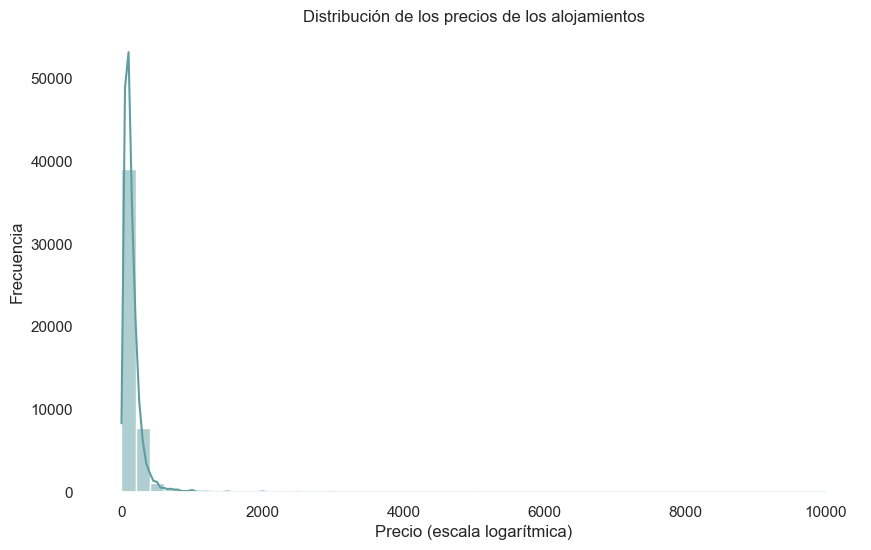

In [454]:
# Resolver acá

precios = df["price"]
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='price', bins=50, color = "cadetblue", kde=True)
plt.title('Distribución de los precios de los alojamientos')
plt.xlabel('Precio (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

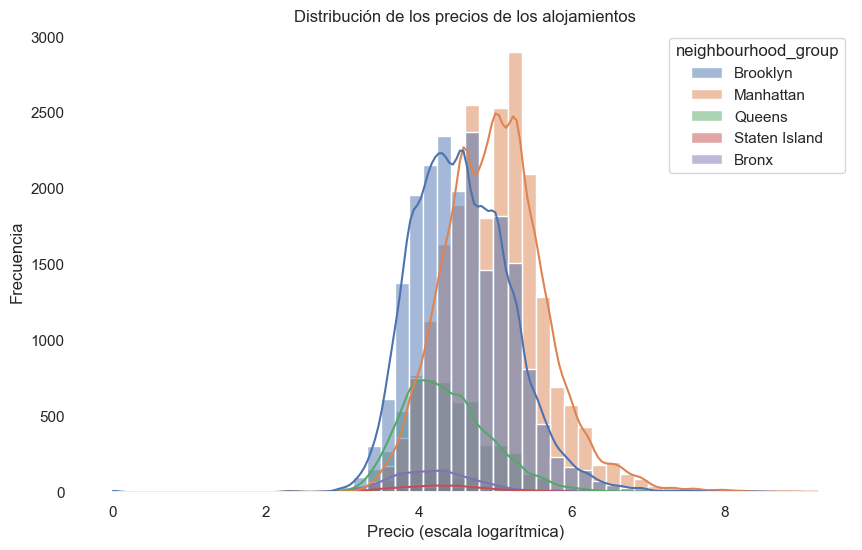

In [369]:
precios = df["price"]
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='price', bins=50, color = "cadetblue", kde=True, hue= "neighbourhood_group")
plt.title('Distribución de los precios de los alojamientos')
plt.xlabel('Precio (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

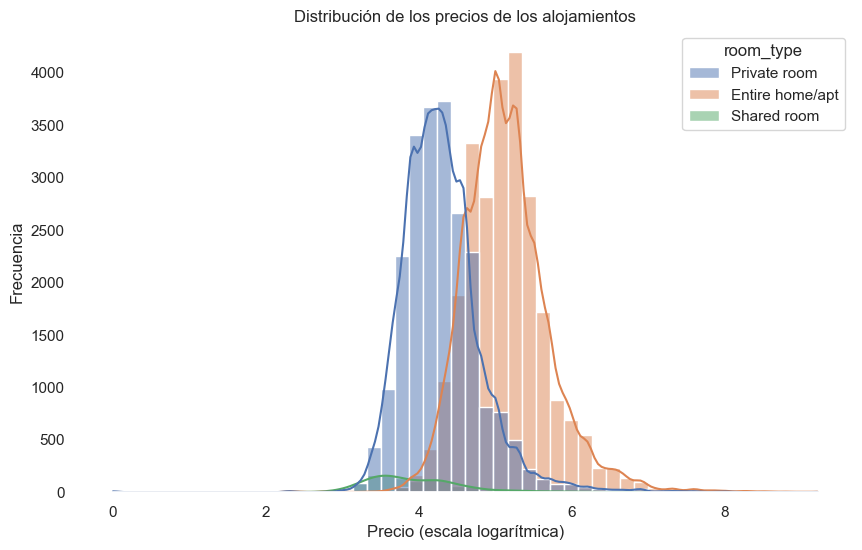

In [370]:
precios = df["price"]
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='price', bins=50, color = "cadetblue", kde=True, hue= "room_type")
plt.title('Distribución de los precios de los alojamientos')
plt.xlabel('Precio (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

#### Ejercicio 5
Realicen dos scatter plots con dos variables de interés en cada uno. Comenten.

<Axes: xlabel='latitude', ylabel='longitude'>

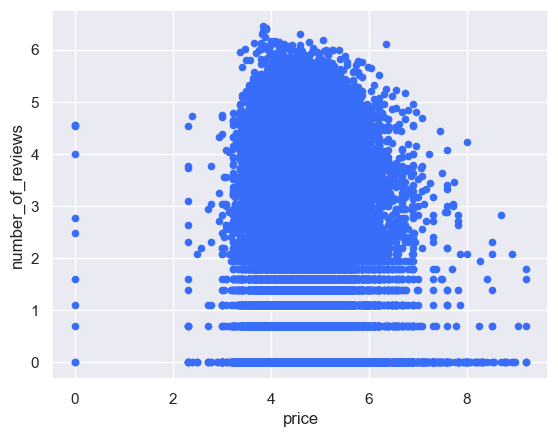

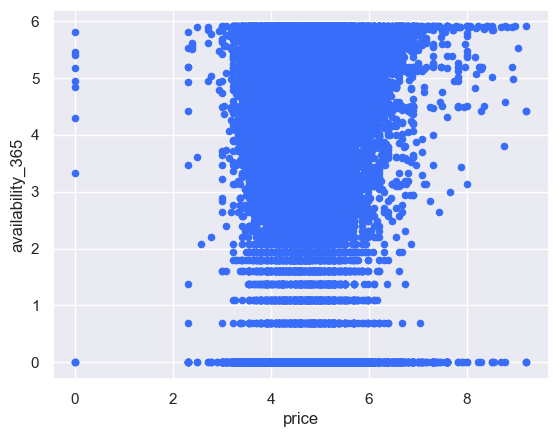

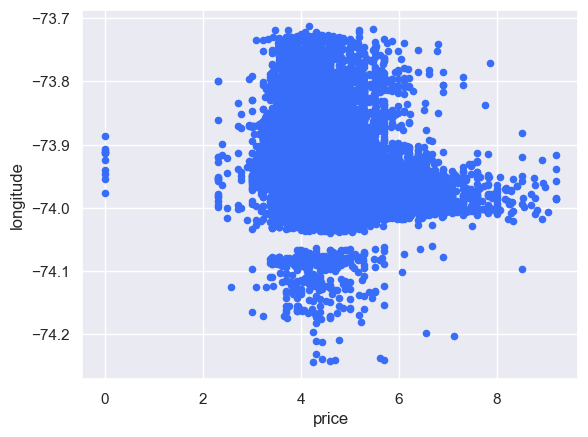

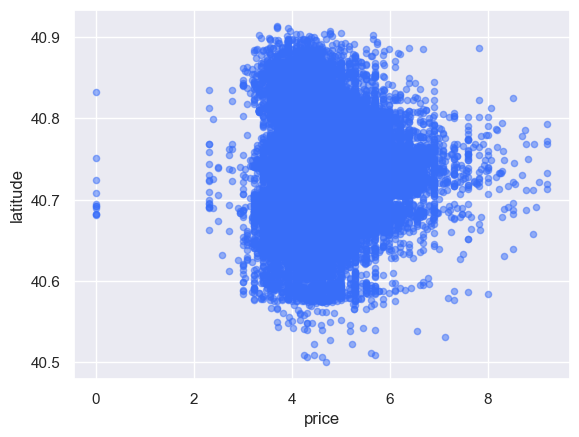

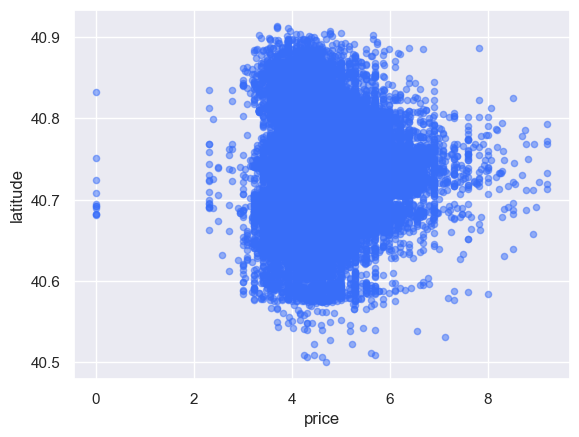

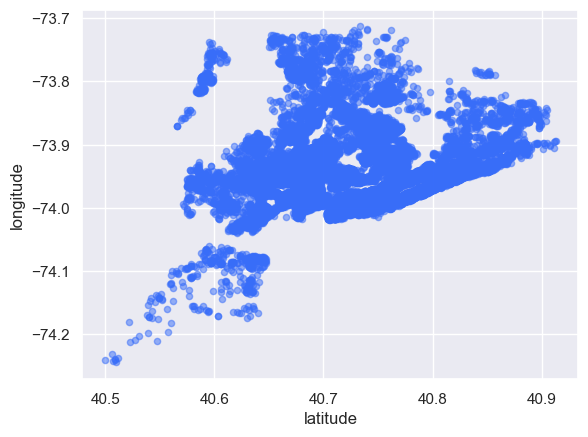

In [145]:
# Resolver acá
df_airbnb4.plot.scatter(x="price", y = "number_of_reviews")
df_airbnb4.plot.scatter(x="price", y = "availability_365")
df_airbnb4.plot.scatter(x="price", y = "longitude")
df_airbnb4.plot.scatter(x="price", y = "latitude", alpha=0.5)
df_airbnb4.plot.scatter(x="price", y = "latitude", alpha=0.5)
df_airbnb4.plot.scatter(x="latitude", y = "longitude", alpha=0.5)

#### Ejercicio 6
Utilicen el análisis de componentes principales para graficar las variables en dos dimensiones. Comenten los resultados obtenidos (qué porcentaje de la varianza se logra explicar con dos componentes, cómo son los *loadings*, si ven algún patrón en el gráfico).

In [455]:
# Resolver acá

df_pca= df.drop(columns=["neighbourhood_group", "neighbourhood", "room_type", "offer_group", "last_review"])

print(df_pca.mean())
print(df_pca.std())

latitude                            40.728950
longitude                          -73.952170
price                              152.732140
minimum_nights                       7.030360
number_of_reviews                   23.277046
reviews_per_month                    1.373266
calculated_host_listings_count       7.138523
availability_365                   112.426268
last_review_days                  2189.989905
neighbourhood_Bronx                  0.022279
neighbourhood_Brooklyn               0.411150
neighbourhood_Manhattan              0.443065
neighbourhood_Queens                 0.115876
neighbourhood_Staten Island          0.007631
room_Entire home/apt                 0.519722
room_Private room                    0.456547
room_Shared room                     0.023732
dtype: float64
latitude                            0.054527
longitude                           0.046156
price                             240.187672
minimum_nights                     20.513052
number_of_reviews      

In [419]:
df_pca.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days,neighbourhood_Bronx,neighbourhood_Brooklyn,neighbourhood_Manhattan,neighbourhood_Queens,neighbourhood_Staten Island,room_Entire home/apt,room_Private room,room_Shared room
0,40.64749,-73.97237,149.0,1,9,0.210000,6,365,2175.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,40.75362,-73.98377,225.0,1,45,0.380000,2,355,1961.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,40.80902,-73.94190,150.0,3,0,1.373221,1,365,2189.925418,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,40.68514,-73.95976,89.0,1,270,4.640000,1,194,1916.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,40.79851,-73.94399,80.0,10,9,0.100000,1,0,2144.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [456]:
# Escalamos las variables, o estandarizamos las variables para que esten en la misma escala y sean comparables. 
# Inicializamos el transformador
scaler = StandardScaler(with_std=True, with_mean=True) 

# Aplicamos fit_transform al DataFrame
df_pca_transformed = pd.DataFrame(scaler.fit_transform(df_pca), columns=df_pca.columns) #transforma el df con los datos estandarizados
print(df_pca_transformed.mean()) # luego de la estandarización la media es cero
print(df_pca_transformed.std()) # la desviación estandar es uno

latitude                         -2.540626e-14
longitude                        -1.377732e-13
price                            -4.651671e-17
minimum_nights                    3.139878e-17
number_of_reviews                -2.791003e-17
reviews_per_month                -5.582005e-17
calculated_host_listings_count    3.721337e-17
availability_365                  0.000000e+00
last_review_days                  1.116401e-15
neighbourhood_Bronx              -3.023586e-17
neighbourhood_Brooklyn            6.512339e-17
neighbourhood_Manhattan          -6.744923e-17
neighbourhood_Queens              1.395501e-17
neighbourhood_Staten Island      -5.233130e-18
room_Entire home/apt             -8.024132e-17
room_Private room                -3.372461e-17
room_Shared room                  2.325835e-17
dtype: float64
latitude                          1.00001
longitude                         1.00001
price                             1.00001
minimum_nights                    1.00001
number_of_reviews 

array([[<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'minimum_nights'}>],
       [<Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'reviews_per_month'}>,
        <Axes: title={'center': 'calculated_host_listings_count'}>,
        <Axes: title={'center': 'availability_365'}>],
       [<Axes: title={'center': 'last_review_days'}>,
        <Axes: title={'center': 'neighbourhood_Bronx'}>,
        <Axes: title={'center': 'neighbourhood_Brooklyn'}>,
        <Axes: title={'center': 'neighbourhood_Manhattan'}>],
       [<Axes: title={'center': 'neighbourhood_Queens'}>,
        <Axes: title={'center': 'neighbourhood_Staten Island'}>,
        <Axes: title={'center': 'room_Entire home/apt'}>,
        <Axes: title={'center': 'room_Private room'}>],
       [<Axes: title={'center': 'room_Shared room'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

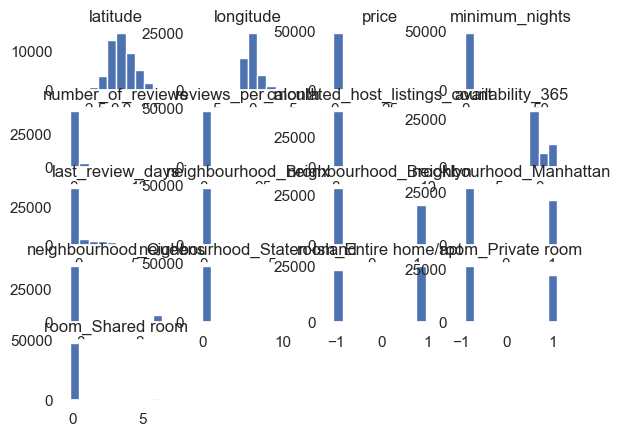

In [421]:
df_pca_transformed.hist()

Text(0.5, 1.0, 'Correlation matrix')

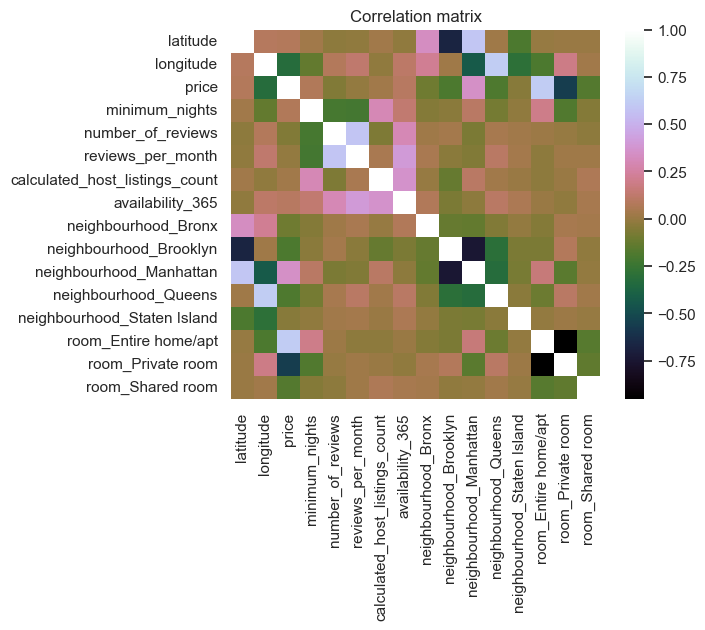

In [160]:
# correlacion2 = df_pca_transformed.corr()
# plt.figure()
# sns.heatmap(correlacion2, vmax=1, square=True,cmap='cubehelix')

# plt.title('Correlation matrix')

In [457]:
missing_values_table(df_pca_transformed)

Your selected dataframe has 17 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [461]:
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_pca_transformed)

In [462]:
print("Varianza explicada:", pca.explained_variance_ratio_)

Varianza explicada: [0.16032268 0.13124133 0.11502567 0.09273759 0.07614441]


In [466]:
# Loadings vectors
loading_vectors = pca.components_ # cada fila corresponde a un CP y cada columna, a una variable
print("Loadings:\n", pca.components_)
print("Loadings del CP1:\n",pca.components_[0]) 
pca.components_[0,0] #loadings del CP1 variable 1

Loadings:
 [[ 0.28338937 -0.33504974  0.2303171   0.11083143 -0.11855845 -0.13602594
   0.16201082 -0.01431069  0.10286588 -0.03109116 -0.33975716  0.48992324
  -0.22619438  0.00913186  0.36634271 -0.36076397 -0.02187292]
 [ 0.46383146  0.29188865 -0.05870848 -0.02800063  0.19685621  0.26801311
   0.0321859   0.18299274 -0.21995095  0.23261224 -0.47401165  0.22994196
   0.29494853 -0.11177015 -0.19181915  0.17942964  0.042438  ]
 [-0.21674388 -0.01147127  0.14493006  0.01066049  0.40132503  0.43773337
   0.10854579  0.30321343 -0.41491922 -0.06194308  0.11325772 -0.12632403
   0.02601545  0.09007953  0.36134786 -0.36226451 -0.00056763]
 [-0.0346591  -0.47649679 -0.09094145 -0.05894422  0.23602996  0.211869
   0.01804389  0.06378518 -0.165343   -0.12519346  0.01788409  0.24781021
  -0.43295821  0.2890989  -0.36718872  0.37853571 -0.0335077 ]
 [-0.13957248  0.00415523  0.03319994  0.49315253 -0.2504037  -0.19022839
   0.52193294  0.50888662 -0.02789073 -0.0877224  -0.02967845 -0.05607394

0.2833893735538804

In [467]:
#deberia dar 1 pero no. es porque hay un monton de componentes principales
(loading_vectors[0,0])**2+(loading_vectors[0,1])**2+(loading_vectors[0,2])**2+(loading_vectors[0,3])**2 + (loading_vectors[0,4])**2 

0.27195354567768054

In [469]:
scores = df_pca_transformed # Salen directamente del elemento arrests_pca
scores[0:5] # Vemos los primeros 5

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_days,neighbourhood_Bronx,neighbourhood_Brooklyn,neighbourhood_Manhattan,neighbourhood_Queens,neighbourhood_Staten Island,room_Entire home/apt,room_Private room,room_Shared room
0,-1.493950,-0.437644,-0.015539,-0.29398,-0.320431,-0.776581,-0.034579,1.898470,-4.062802e-02,-0.150953,1.196747,-0.891931,-0.362026,-0.08769,-1.040253,1.091035,-0.155912
1,0.452435,-0.684634,0.300884,-0.29398,0.487545,-0.663091,-0.156066,1.823305,-6.206447e-01,-0.150953,-0.835598,1.121163,-0.362026,-0.08769,0.961305,-0.916561,-0.155912
2,1.468451,0.222512,-0.011375,-0.19648,-0.522425,0.000000,-0.186438,1.898470,1.232528e-15,-0.150953,-0.835598,1.121163,-0.362026,-0.08769,-1.040253,1.091035,-0.155912
3,-0.803463,-0.164438,-0.265346,-0.29398,5.537399,2.180828,-0.186438,0.613149,-7.426109e-01,-0.150953,1.196747,-0.891931,-0.362026,-0.08769,0.961305,-0.916561,-0.155912
4,1.275702,0.177231,-0.302817,0.14477,-0.320431,-0.850016,-0.186438,-0.845052,-1.246491e-01,-0.150953,-0.835598,1.121163,-0.362026,-0.08769,0.961305,-0.916561,-0.155912


In [470]:
# Biplot
# Ajustes, extendemos longitud de las flechas e invertimos el eje y

i, j = 0, 1 # Componentes

scale_arrow = s_ = 2 # para extender la longitud de las flechas y que se vean mejor
scores[:,1] *= -1
pca.components_[1] *= -1 # gira el eje y (CP2)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(scores[:,0], scores[:,1]) 
ax.set_xlabel('CP%d' % (i+1))
ax.set_ylabel('CP%d' % (j+1))
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])
    ax.text(s_*pca.components_[i,k], s_*pca.components_[j,k], df_pca_transformed.columns[k])

InvalidIndexError: (slice(None, None, None), 1)

### Parte III: Predicción

El objetivo de esta parte del trabajo es intentar predecir los precios de los alojamientos.

#### Ejercicio 7
Eliminen de la base todas las variables relacionadas al precio

In [173]:
# Resolver acá
#NO HAGAMOS EL 7
columns_to_remove = ['price', 'minimum_nights']

# Eliminar las columnas del DataFrame
df_airbnb_cleaned = df_airbnb.drop(columns=columns_to_remove)

# Mostrar las primeras filas del DataFrame limpio
print(df_airbnb_cleaned.head())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  number_of_reviews last_review  reviews_per_month  \
0     Private room                  9  2018-10-19               0.21

#### Ejercicio 8
Partan la base en una base de prueba (test) y una de entrenamiento (train) utilizando el comando <code>train_test_split</code>. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (*random state instance*) debe ser 201. Establezca a price como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables ser´an las variables independientes (matriz X). Recuerden agregar la columna de unos (1).

In [174]:
# Resolver acá
from sklearn.model_selection import train_test_split
import pandas as pd

# Definir la variable dependiente (y) y las independientes (X)
y = df_airbnb['price']  # Asegúrate de que 'price' sea la variable correcta
X = df_airbnb.drop(columns=['id','name','host_id','host_name','neighbourhood_group','neighbourhood','latitude','longitude','room_type','minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count','availability_365'])  # Eliminar la variable dependiente de X

# Partir la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

# Agregar una columna de unos (intercepto) a la matriz X
import numpy as np

X_train = np.c_[np.ones(X_train.shape[0]), X_train]  # Añade columna de unos al conjunto de entrenamiento
X_test = np.c_[np.ones(X_test.shape[0]), X_test]      # Añade columna de unos al conjunto de prueba

# Mostrar las dimensiones de los conjuntos
print("Dimensiones del conjunto de entrenamiento X:", X_train.shape)
print("Dimensiones del conjunto de prueba X:", X_test.shape)
print("Dimensiones del conjunto de entrenamiento y:", y_train.shape)
print("Dimensiones del conjunto de prueba y:", y_test.shape)

Dimensiones del conjunto de entrenamiento X: (34226, 2)
Dimensiones del conjunto de prueba X: (14669, 2)
Dimensiones del conjunto de entrenamiento y: (34226,)
Dimensiones del conjunto de prueba y: (14669,)


#### Ejercicio 9
Implementen una regresión lineal y comenten los resultados obtenidos.

In [471]:
# Resolver acá
# Resolver acá
from sklearn.linear_model import LinearRegression


# Crear una instancia del modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)


from sklearn.metrics import mean_squared_error, r2_score

# Calcular MSE y R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")


# Coeficientes del modelo
coefficients = model.coef_
feature_names = X_train.columns  # Ajusta si es necesario

# Crear un DataFrame para mostrar los coeficientes
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_df)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values